Notebook which uses the OM-optimized Muller-Brown transition paths from diffusion_mb.ipynb to estimate the committor function and subsequently the transition rate between energy wells, using the formalism of the Backward Kolmogorov Equation. The method is largely inspired from this paper: 
Hasyim, et. al (JCP 2022): "Supervised learning and the finite-temperature string method for computing committor functions and reaction rates": https://pubs.aip.org/aip/jcp/article/157/18/184111/2842057/Supervised-learning-and-the-finite-temperature

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from mb_dataset import MBDataset
from mb_calculator import MullerBrownPotential
import os
calculator = MullerBrownPotential(device = "cpu")

# load dataset constructed in diffusion_mb.ipynb
dataset = MBDataset(preload_sim_dir="data/diffusion_data_new_t=0_fewersims_long/temp=700_timestep=5.0_friction=0.001", device = "cuda")


/home/sanjeevr/miniforge3/envs/alphaflow/lib/python3.9/site-packages/ase/optimize/gpmin/gpmin.py:4: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.2)
  from scipy.optimize import minimize


Loading simulations from directory: data/diffusion_data_new_t=0_fewersims_long/temp=700_timestep=5.0_friction=0.001


100%|██████████| 100/100 [02:40<00:00,  1.60s/it]


In [20]:
device = torch.device("cuda")
from tqdm import tqdm

#Define some utility functions

def plot_samples(samples: np.ndarray, committor_probs: np.ndarray, plot_transition = False, title: str = "Muller Brown Samples") -> None:
    # plot a single plot with samples
    fig, ax = plt.subplots()
    num_points = 100
    x_values = torch.linspace(calculator.Lx, calculator.Hx , num_points)
    y_values = torch.linspace(calculator.Ly, calculator.Hy, num_points)

    x, y = torch.meshgrid(x_values, y_values, indexing = "xy")
    z = calculator.U_split(x, y).cpu()
    
        
    # colorbar = ax.imshow(z, extent=(x_values.min(), x_values.max(), y_values.min(), y_values.max()), vmin=calculator.U_min, vmax=calculator.U_max, origin='lower', cmap='viridis', aspect='auto')
    
    scatter1 = ax.scatter(samples[:, 0], samples[:, 1], s = 0.3, c = committor_probs, cmap='coolwarm')
    plt.colorbar(scatter1, ax=ax, label='Committor Probability')

    if plot_transition:
        transition_mask = torch.logical_and(committor_probs > 0.45 , committor_probs < 0.55).reshape(-1)
        ax.scatter(samples[transition_mask, 0], samples[transition_mask, 1], c = "green", label = "Transition")

    ax.set_xlim([calculator.Lx, calculator.Hx])
    ax.set_ylim([calculator.Ly, calculator.Hy])
    plt.title(title)
    plt.show()
    plt.close()

def linear_warmup_cosine_decay_lr_scheduler(optimizer, warmup_steps, total_steps, lr_min=0.0, lr_max=1.0):
    """
    Linear warmup with cosine decay 
    """
    def lr_lambda(current_step: int):
        if current_step < warmup_steps:
            # Linear warmup
            warmup_factor = current_step / float(max(1, warmup_steps))
            return lr_min + warmup_factor * (lr_max - lr_min)
        else:
            # Cosine decay
            progress = (current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
            return lr_min + 0.5 * (lr_max - lr_min) * (1 + torch.cos(torch.tensor(torch.pi * progress)))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

def plot_losses(
    train_losses: np.ndarray, test_losses: np.ndarray, title: str, reference_rate=2.02e-12,
) -> None:
    plt.figure()
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, train_losses, label="train loss")
    plt.plot(x_test, test_losses, label="test loss")
    plt.axhline(reference_rate, color="r", linestyle="--", label="Reference (FEM) rate")
    plt.legend()
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.yscale("log")

In [6]:
from tqdm import tqdm
def get_gt_committor_probs(trajectories, is_start, is_end, calculator, bins_per_dim=100):
    """
    trajectories: torch.tensor of shape (# Trajectories, Length, 2)
    is_start: boolean of whether the config is in the start basin
    is_end: boolean of whether the config is in the end basin
    """
    T, L = trajectories.shape[0], trajectories.shape[1]
    bin_edges_x = np.linspace(calculator.Lx, calculator.Hx, bins_per_dim+1)
    bin_edges_y = np.linspace(calculator.Ly, calculator.Hy, bins_per_dim+1)
    bins_x = np.digitize(trajectories[:, :, 0], bin_edges_x) - 1
    bins_y = np.digitize(trajectories[:, :, 1], bin_edges_y) - 1
    # Clip to ensure all indices are within bounds
    bins_x = np.clip(bins_x, 0, bins_per_dim - 1)
    bins_y = np.clip(bins_y, 0, bins_per_dim - 1)
    
    # Create bin index based on (x, y) bin pairs
    bin_idx = bins_x * bins_per_dim + bins_y
    
    # Initialize committor probabilities tensor
    committor_probs = torch.zeros(bins_per_dim ** 2)
    bin_counts = torch.zeros(bins_per_dim ** 2)
    
    
    # Iterate over samples to assign committor probabilities
    for traj in tqdm(range(T)):
        last_committor = None
        last_transition_idx = None
        for i in range(L):
            bin_counts[bin_idx[traj, i]] += 1
            if last_transition_idx is not None and i <= last_transition_idx:
                # If we already determined the committor for the intermediate steps, assign and skip
                committor_probs[bin_idx[traj, i]] += last_committor
            else:
                if is_start[traj, i]:
                    committor_probs[bin_idx[traj, i]] += 0
                    last_committor = 0
                    last_transition_idx = i
                elif is_end[traj, i]:
                    committor_probs[bin_idx[traj, i]] += 1
                    last_committor = 1
                    last_transition_idx = i
                else:
                    # Search forward in the trajectory to find the next transition
                    subsequent_start = is_start[traj, i:]
                    subsequent_end = is_end[traj, i:]
                    first_start = np.argmax(subsequent_start)
                    first_end = np.argmax(subsequent_end)

                    if (first_end == 0 or first_start > 0 and first_start < first_end):
                        last_committor = 0
                        last_transition_idx = i + first_start
                    elif (first_end > 0 and (first_start == 0 or first_end < first_start)):
                        last_committor = 1
                        last_transition_idx = i + first_end
                    else:
                        raise RuntimeError(f"No transition found for sample {i}")
                    
                    # Assign committor for current step
                    committor_probs[bin_idx[traj, i]] += last_committor
    
    # Normalize committor probabilities by bin counts
    committor_probs = committor_probs / torch.clamp(bin_counts, min=1)
    
    # Save bin-wise committor probabilities
    np.save("gt_committor_probs.npy", committor_probs)
    
    return committor_probs[bin_idx]

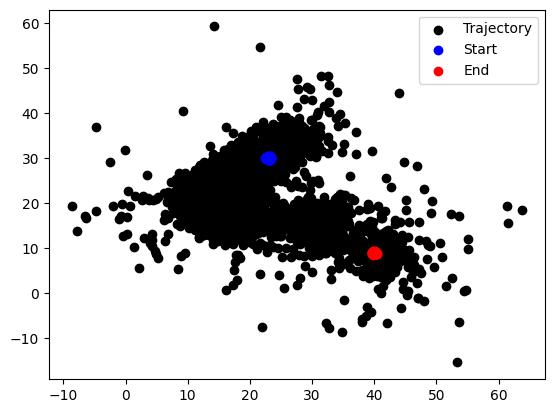

In [11]:
mean = np.load("data/mb_mean.npy")
std = np.load("data/mb_std.npy")
all_pos = mean + std*dataset.all_pos.reshape(-1, 1000, 3)[:, :, :2]
# all_pos = dataset.all_pos.reshape(-1, 1000, 3)[:, :, :2]
# all_pos = torch.tensor(np.load("mb_diffusion_iid_samples.npy")).float().reshape(-1, 1000, 2)
start = np.array([[23, 30]]) # start basin
end = np.array([[40, 9]]) # end basin

# define start and end wells as an l2 norm ball with radius 0.5
start_indicator = np.linalg.norm(all_pos - start, axis=2) < 0.5
end_indicator = np.linalg.norm(all_pos - end, axis=2) < 0.5

start_points = all_pos[start_indicator]
end_points = all_pos[end_indicator]
plt.scatter(all_pos[:, ::10, 0], all_pos[:, ::10, 1], c = "black", label = "Trajectory")

plt.scatter(start_points[::10, 0], start_points[::10, 1], c = "blue", label = "Start")
plt.scatter(end_points[::10, 0], end_points[::10, 1], c = "red", label = "End")
plt.legend()

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:12<00:00, 79.18it/s]


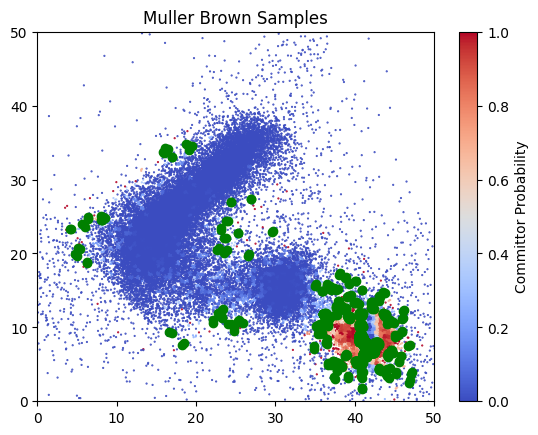

In [13]:
committor_probs  = get_gt_committor_probs(all_pos, start_indicator,end_indicator, calculator)
plot_samples(all_pos.reshape(-1, 2), committor_probs.reshape(-1, 2))

/tmp/ipykernel_126879/3488134907.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(mean).to(device).to(torch.float32)
/tmp/ipykernel_126879/3488134907.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainset = torch.utils.data.TensorDataset(torch.tensor(x_train), torch.tensor(start_train), torch.tensor(end_train), torch.tensor(probs_train), torch.tensor(weight_train))
/tmp/ipykernel_126879/3488134907.py:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testset = torch.utils.data.TensorDataset(torch.tensor(x_te

Epoch  1


100%|██████████| 196/196 [00:15<00:00, 12.33it/s]


Epoch  2


100%|██████████| 196/196 [00:15<00:00, 12.68it/s]


Epoch  3


100%|██████████| 196/196 [00:15<00:00, 12.85it/s]


Epoch  4


100%|██████████| 196/196 [00:15<00:00, 12.94it/s]


Epoch  5


100%|██████████| 196/196 [00:15<00:00, 12.86it/s]


Epoch  6


100%|██████████| 196/196 [00:15<00:00, 12.57it/s]


Epoch  7


100%|██████████| 196/196 [00:15<00:00, 12.26it/s]


Epoch  8


100%|██████████| 196/196 [00:15<00:00, 12.56it/s]


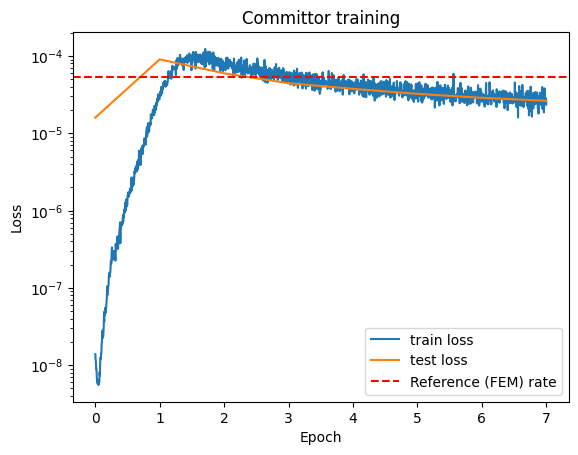

In [19]:
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm
from ase import units
from mb_ddpm import MLP

# print("Computing empirical committor probabilities from MD simulations")
# committor_probs  = get_gt_committor_probs(all_pos, start_indicator,end_indicator, calculator)
# plot_samples(all_pos.reshape(-1, 2), committor_probs.reshape(-1, 2))

class CommittorMLP(torch.nn.Module):
    """
    Simple MLP to parameterize a learnable committor function $$q_\theta(x)$$.
    """
    def __init__(self, in_dim, hidden_dim, out_dim, device, act = F.relu):
        super(CommittorMLP, self).__init__()
        self.device = device
        self.in_dim = in_dim
        # self.mean = torch.tensor(train_dataset.mean).to(device).to(torch.float32)
        # self.std = torch.tensor(train_dataset.std).to(device).to(torch.float32)
        mean = torch.tensor(np.load("data/mb_mean.npy")).to(device).to(torch.float32)
        std = torch.tensor(np.load("data/mb_std.npy")).to(device).to(torch.float32)

        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim) 
        self.fc3 = nn.Linear(hidden_dim, hidden_dim) 
        self.fc4 = nn.Linear(hidden_dim, hidden_dim) 
        self.act = act
        self.fc5 = nn.Linear(hidden_dim, out_dim)  
        self.sigmoid = torch.nn.Sigmoid()


    def forward(self, x):        
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        x = self.act(self.fc4(x))
        x = self.fc5(x)
        committor_prob = self.sigmoid(x)
        return committor_prob


committor_model = CommittorMLP(2, 64, 1, device).to(device)

mean = torch.tensor(mean).to(device).to(torch.float32)
std = torch.tensor(mean).to(device).to(torch.float32)

# Train the model on the sampled molecules

n_steps = 2000 # total number of training steps
batch_size = 4096
max_data_size = 1000000 # use all the data (1M samples)
n_steps = max(n_steps, max_data_size // batch_size) # at least one epoch
filter_transition = False # exclude transition samples from the BKE loss
sl_loss_coeff = 0.0 # coefficient for supervised learning
grad_loss_coeff = 1.0 # coefficient for BKE loss
start_loss_coeff = 20.0 # coefficient for start boundary loss
end_loss_coeff = 20.0 # coefficient for end boundary loss
gt_traj = all_pos.reshape(-1, 2)
idxs = np.random.choice(gt_traj.shape[0], max_data_size, replace=False)
optimizer = torch.optim.Adam(committor_model.parameters(), lr=1e-4)
scheduler = linear_warmup_cosine_decay_lr_scheduler(optimizer, warmup_steps = 0, \
                                                        total_steps = n_steps, \
                                                        lr_min=0.7, lr_max=1.0)
n_epochs = int(n_steps / (max_data_size // batch_size))
train_losses = []
test_losses = []

# split sampled_mol and cluster_assignments into train test sets
gt_traj_keep = gt_traj[idxs]

# Compute importance-sampling weights (density ratios) from the Muller-Brown potential 
# (assumes we have access to the true potential)
energies = calculator.get_energy(gt_traj_keep)
min_energy = energies.min()
empirical_density, bin_edges_x, bin_edges_y = np.histogram2d(
            gt_traj_keep[:, 0],
            gt_traj_keep[:, 1],
            bins=1000,
            density=True,
    )
# Digitize samples into bins
bins_x = np.digitize(gt_traj_keep[:, 0], bin_edges_x) - 1
bins_y = np.digitize(gt_traj_keep[:, 1], bin_edges_y) - 1

# Clip to ensure all indices are within bounds
bins_x = np.clip(bins_x, 0, 999)
bins_y = np.clip(bins_y, 0, 999)

empirical_density = torch.tensor(empirical_density[bins_x, bins_y])

reweighting_factors_keep = torch.exp(-(energies - min_energy)) / empirical_density # set k_BT = 1
reweighting_factors_keep = reweighting_factors_keep / reweighting_factors_keep.sum()

start_mask_keep = start_indicator.reshape(-1, 1)[idxs]
end_mask_keep = end_indicator.reshape(-1, 1)[idxs]

gt_probs_keep = committor_probs.reshape(-1,1)[idxs]

x_train, x_test, start_train, start_test, end_train, end_test, probs_train, probs_test, weight_train, weight_test = train_test_split(gt_traj_keep, start_mask_keep, end_mask_keep, gt_probs_keep, reweighting_factors_keep, test_size=0.2)
trainset = torch.utils.data.TensorDataset(torch.tensor(x_train), torch.tensor(start_train), torch.tensor(end_train), torch.tensor(probs_train), torch.tensor(weight_train))
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torch.utils.data.TensorDataset(torch.tensor(x_test), torch.tensor(start_test), torch.tensor(end_test), torch.tensor(probs_test), torch.tensor(weight_test))
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

for e in range(n_epochs):
    committor_model.train()
    print("Epoch ", e+1)
    for x, start, end, prob, weights in tqdm(train_dataloader):
        weights = weights.unsqueeze(-1).to(device)
        optimizer.zero_grad()
        x = x.to(device).requires_grad_(True)
        x = (x - mean) / std
        x = x.to(torch.float32)
        start = start.to(device)
        end = end.to(device)
        prob = prob.to(device)
        if filter_transition:
            transition_mask = torch.logical_and(~start, ~end)
        else:
            transition_mask = torch.ones_like(start)
        pred_prob = committor_model(x)
        grad_prob = torch.autograd.grad(
            outputs=pred_prob,  # [batch_size]
            inputs=x,  # [batch_size, 2]
            grad_outputs=torch.ones_like(pred_prob),
            retain_graph=True,  # Make sure the graph is not destroyed during training
            create_graph=True,  # Create graph for second derivative
            allow_unused=True,
            )[0]
        grad_loss = 0
        start_boundary_loss = 0
        end_boundary_loss = 0

        # if transition_mask.sum() > 0:
        batch_weights = weights[transition_mask]
        batch_weights = batch_weights / batch_weights.sum()
        grad_loss = (batch_weights * (grad_prob/std).square().sum(-1, keepdim = True)[transition_mask]).sum()
        if start.sum() > 0:
            start_boundary_loss = (pred_prob**2)[start].mean()
        if end.sum() > 0:
            end_boundary_loss = ((1 - pred_prob)**2)[end].mean()
        
        sl_loss = (pred_prob - prob).square().mean()

        loss = sl_loss_coeff*sl_loss + start_loss_coeff*start_boundary_loss + end_loss_coeff*end_boundary_loss + grad_loss_coeff*grad_loss

        loss.backward()
        optimizer.step()
        scheduler.step()
        train_losses.append(grad_loss.detach().unsqueeze(-1))
        
    # Test the model on the test set
    committor_model.eval()
    tls = []
    for x, start, end, prob, weights in test_dataloader:
        weights = weights.unsqueeze(-1).to(device)
        x = x.to(device).requires_grad_(True)
        x = (x - mean) / std
        x = x.to(torch.float32)
        start = start.to(device)
        end = end.to(device)
        prob = prob.to(device)
        if filter_transition:
            transition_mask = torch.logical_and(~start, ~end)
        else:
            transition_mask = torch.ones_like(start)
        pred_prob = committor_model(x)
        grad_prob = torch.autograd.grad(
            outputs=pred_prob,  # [batch_size]
            inputs=x,  # [batch_size, 2]
            grad_outputs=torch.ones_like(pred_prob),
            retain_graph=True,  # Make sure the graph is not destroyed during training
            create_graph=True,  # Create graph for second derivative
            allow_unused=True,
            )[0]
        grad_loss = 0
        start_boundary_loss = 0
        end_boundary_loss = 0
        
        batch_weights = weights[transition_mask]
        batch_weights = batch_weights / batch_weights.sum()
        grad_loss = (batch_weights * (grad_prob/std).square().sum(-1, keepdim = True)[transition_mask]).sum()
        if start.sum() > 0:
            start_boundary_loss = (pred_prob**2)[start].mean()
        if start.sum() > 0:
            end_boundary_loss = ((1 - pred_prob)**2)[end].mean()

        sl_loss = (pred_prob - prob).square().mean()

        loss = sl_loss_coeff*sl_loss + start_loss_coeff*start_boundary_loss + end_loss_coeff*end_boundary_loss + grad_loss_coeff*grad_loss
        
        tls.append(grad_loss.detach().unsqueeze(-1))
    
    test_loss = torch.cat(tls).sum(0) / len(tls)
    test_losses.append(test_loss.unsqueeze(-1))


train_losses = torch.cat(train_losses).cpu().numpy()
test_losses = torch.cat(test_losses).cpu().numpy()

plot_losses(train_losses, test_losses, "Committor training", reference_rate=5.38e-05) # Reference rate from FEM calculations

# Save the model
os.makedirs("results/checkpoints", exist_ok=True)
torch.save(committor_model, f"results/checkpoints/mb-committor-model.pt")

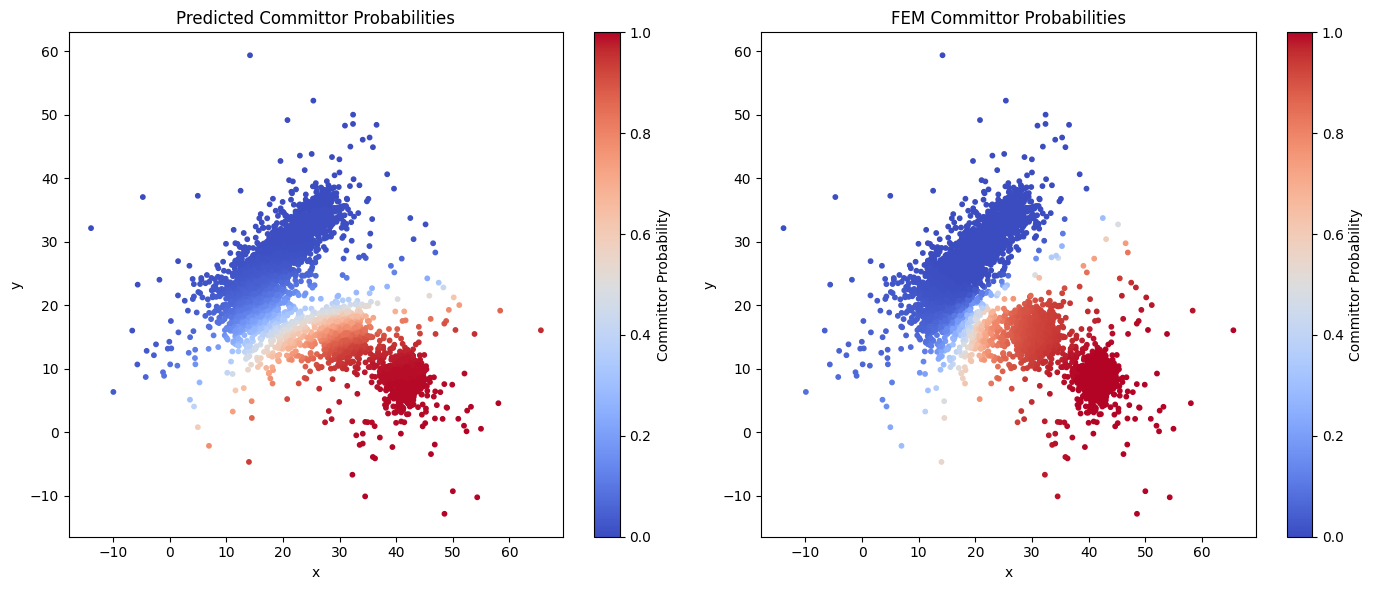

In [25]:
from scipy.spatial import cKDTree

# Compute model predicted committor probabilities by looping over the dataset


committor_model.eval()

committor_probs = []
samples = torch.tensor(gt_traj_keep)
for x in samples.split(batch_size):
    x = x.to(device).requires_grad_(True)
    x = (x - mean) / std
    x = x.to(torch.float32)
    pred_prob = committor_model(x)
    committor_probs.append(pred_prob.detach())

committor_probs = torch.cat(committor_probs).cpu().numpy()


# Load ground truth committor values
fem_committor = np.loadtxt("data/committor/fem_committor.txt")
n_struct = 100

# Generate the meshgrid
points_x = np.linspace(calculator.Lx, calculator.Hx, n_struct)
points_y = np.linspace(calculator.Ly, calculator.Hy, n_struct)
xx, yy = np.meshgrid(points_x, points_y)

# Flatten the meshgrid to use in KDTree
mesh_points = np.vstack([xx.ravel(), yy.ravel()]).T

# Build a KDTree for nearest neighbor lookup
tree = cKDTree(mesh_points)

# Find the nearest neighbors in the mesh for each sample point
_, nearest_idx = tree.query(samples)

# Extract corresponding ground truth committor values
nearest_committor_values = fem_committor.ravel()[nearest_idx]

# Create a side-by-side plot
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot the predicted committor probabilities
scatter1 = axs[0].scatter(samples[::10, 0], samples[::10, 1], c=committor_probs[::10], cmap='coolwarm', s=10)
axs[0].set_title('Predicted Committor Probabilities')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
plt.colorbar(scatter1, ax=axs[0], label='Committor Probability')
scatter1.set_clim(0, 1)

# Plot only the ground truth committor probabilities at the sample points
scatter2 = axs[1].scatter(samples[::10, 0], samples[::10, 1], c=nearest_committor_values[::10], cmap='coolwarm', s=10)
axs[1].set_title('FEM Committor Probabilities')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
plt.colorbar(scatter2, ax=axs[1], label='Committor Probability')
scatter2.set_clim(0, 1)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [26]:
from ase import units
def compute_rates(samples, weights, committor_model, calculator):
    """
    samples: torch.tensor of shape [N_samples, 2]
    weights: torch.tensor of shape [N_samples, 1]
    committor_model: NN trained to predict committor probabilities
    calculator: calculator that returns energies of samples (ideally we won't need this when we get the model log likelihoods working)
    """
    weights = weights / weights.sum()
    # Loop over samples and compute grad of model-predicted committors
    committor_model.eval()
    committor_probs = []
    grad_committor_prob_norms = []
    for x in tqdm(samples.split(batch_size)):
        x = x.to(device).requires_grad_(True)
        x = (x - mean) / std
        x = x.to(torch.float32)
        pred_prob = committor_model(x)
        grad_prob = torch.autograd.grad(
            outputs=pred_prob,  # [batch_size]
            inputs=x,  # [batch_size, 2]
            grad_outputs=torch.ones_like(pred_prob),
            retain_graph=True,  # Make sure the graph is not destroyed during training
            create_graph=True,  # Create graph for second derivative
            allow_unused=True,
            )[0]
        grad_committor_prob_norms.append(1/2 * torch.norm(grad_prob / std, dim=-1)**2)
    
    grad_committor_prob_norms = torch.cat(grad_committor_prob_norms)
    
    # Compute a weighted average of the grad of the committor (this is the rate)
    ensemble_average = (weights * grad_committor_prob_norms).sum()
    rate = ensemble_average # undo the normalization of the input
    N_eff = (-weights * torch.log(weights+1e-20)).sum().exp()  # effective sample size

    print(f"Rate: {rate.item()}, Effective sample size: {N_eff} out of {len(samples)} samples")
    return rate, N_eff, grad_committor_prob_norms

rate, N_eff, grad_committor_prob_norms = compute_rates(torch.tensor(gt_traj_keep), torch.tensor(reweighting_factors_keep).to(device), committor_model, calculator)



/tmp/ipykernel_126879/1761884593.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rate, N_eff, grad_committor_prob_norms = compute_rates(torch.tensor(gt_traj_keep), torch.tensor(reweighting_factors_keep).to(device), committor_model, calculator)
  0%|          | 0/245 [00:00<?, ?it/s]

100%|██████████| 245/245 [00:00<00:00, 403.81it/s]

Rate: 1.3282344647512558e-05, Effective sample size: 20355.643376329113 out of 1000000 samples


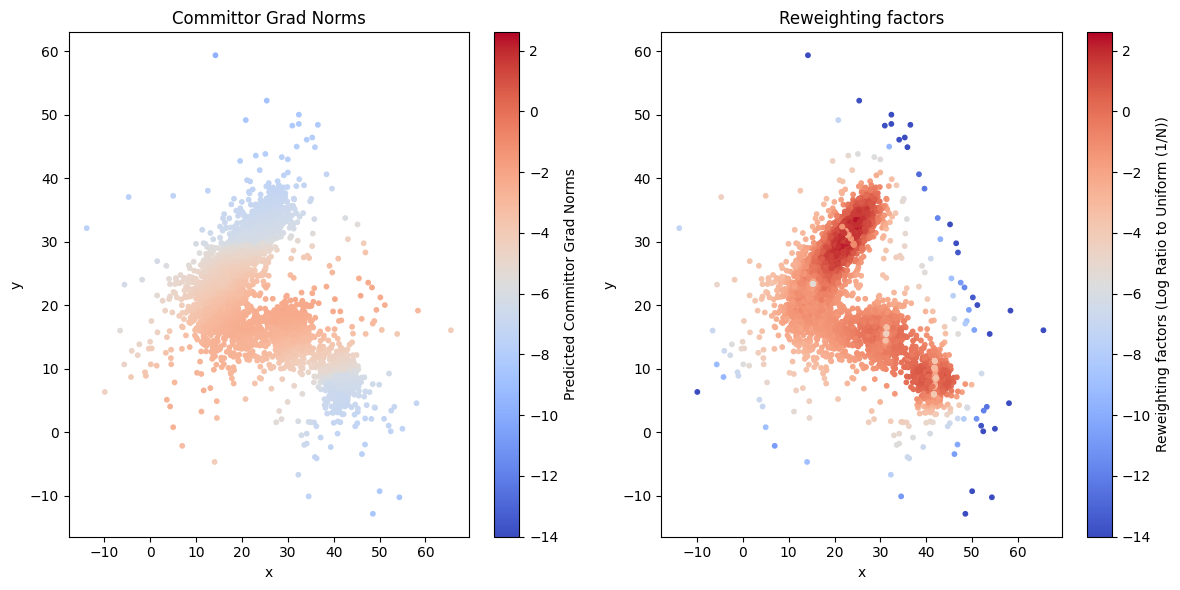

In [24]:
import matplotlib.pyplot as plt

# Create a side-by-side plot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Compute log-scaled values safely
committor_grad_norms_log = grad_committor_prob_norms.detach().cpu().log10()
reweighting_factors_log = (len(reweighting_factors_keep) * (reweighting_factors_keep+1e-20)).detach().cpu().log10() # multiply by length to be comparable to uniform dist

# Define color limits
vmin, vmax = min(committor_grad_norms_log[::10].min(), reweighting_factors_log[::10].min()), max(committor_grad_norms_log[::10].max(), reweighting_factors_log[::10].max())

# Plot the predicted committor probabilities
scatter1 = axs[0].scatter(samples[::10, 0], samples[::10, 1], c=committor_grad_norms_log[::10], cmap='coolwarm', s=10, vmin=vmin, vmax=vmax)
axs[0].set_title('Committor Grad Norms')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
cbar1 = plt.colorbar(scatter1, ax=axs[0], label='Predicted Committor Grad Norms')

# Plot only the ground truth committor probabilities at the sample points
scatter2 = axs[1].scatter(samples[::10, 0], samples[::10, 1], c=reweighting_factors_log[::10], cmap='coolwarm', s=10, vmin=vmin, vmax=vmax)
axs[1].set_title('Reweighting factors')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
cbar2 = plt.colorbar(scatter2, ax=axs[1], label='Reweighting factors (Log Ratio to Uniform (1/N))')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()
